In [78]:
import pandas as pd
import glob
import itertools

# --- Step 1: Read and process pollutant CSV files using the numeric month (month_num) ---

# NO2
df_no2 = pd.read_csv("NO2.csv")
df_no2 = df_no2[['NUTS_ID', 'year', 'month_num', 'no2_B0_mean']]
df_no2.rename(columns={'no2_B0_mean': 'NO2', 'month_num': 'month'}, inplace=True)
df_no2['year'] = df_no2['year'].astype(int)
df_no2['month'] = df_no2['month'].astype(int)

# SO2
df_so2 = pd.read_csv("SO2.csv")
df_so2 = df_so2[['NUTS_ID', 'year', 'month_num', 'so2_B0_mean']]
df_so2.rename(columns={'so2_B0_mean': 'SO2', 'month_num': 'month'}, inplace=True)
df_so2['year'] = df_so2['year'].astype(int)
df_so2['month'] = df_so2['month'].astype(int)

# CO
df_co = pd.read_csv("CO.csv")
df_co = df_co[['NUTS_ID', 'year', 'month_num', 'co_B0_mean']]
df_co.rename(columns={'co_B0_mean': 'CO', 'month_num': 'month'}, inplace=True)
df_co['year'] = df_co['year'].astype(int)
df_co['month'] = df_co['month'].astype(int)

# O3
df_o3 = pd.read_csv("O3.csv")
df_o3 = df_o3[['NUTS_ID', 'year', 'month_num', 'o3_B0_mean']]
df_o3.rename(columns={'o3_B0_mean': 'O3', 'month_num': 'month'}, inplace=True)
df_o3['year'] = df_o3['year'].astype(int)
df_o3['month'] = df_o3['month'].astype(int)

# HCHO
df_hcho = pd.read_csv("HCHO.csv")
df_hcho = df_hcho[['NUTS_ID', 'year', 'month_num', 'hcho_B0_mean']]
df_hcho.rename(columns={'hcho_B0_mean': 'HCHO', 'month_num': 'month'}, inplace=True)
df_hcho['year'] = df_hcho['year'].astype(int)
df_hcho['month'] = df_hcho['month'].astype(int)

# PM25
df_pm25 = pd.read_csv("PM25.csv")
df_pm25 = df_pm25[['NUTS_ID', 'year', 'month', 'mean']]
df_pm25.rename(columns={'mean': 'PM25'}, inplace=True)
df_pm25['year'] = df_pm25['year'].astype(int)
df_pm25['month'] = df_pm25['month'].astype(int)

# --- Step 2: Merge pollutant datasets on NUTS_ID, year, and month using outer joins ---
df_pollutants = df_no2.merge(df_so2, on=['NUTS_ID', 'year', 'month'], how='outer')
df_pollutants = df_pollutants.merge(df_co, on=['NUTS_ID', 'year', 'month'], how='outer')
df_pollutants = df_pollutants.merge(df_o3, on=['NUTS_ID', 'year', 'month'], how='outer')
df_pollutants = df_pollutants.merge(df_hcho, on=['NUTS_ID', 'year', 'month'], how='outer')
df_pollutants = df_pollutants.merge(df_pm25, on=['NUTS_ID', 'year', 'month'], how='outer')

# --- Step 3: Read and merge GDP data (annual) using semicolon as the delimiter ---
df_gdp = pd.read_csv("GDP.csv", delimiter=";")
# Remove extra whitespace from GDP file column names
df_gdp.columns = df_gdp.columns.str.strip()
print("GDP file columns:", df_gdp.columns)  # For debugging

# Rename 'Year' to 'year'
df_gdp.rename(columns={'Year': 'year'}, inplace=True)
df_gdp = df_gdp[['NUTS_ID', 'year', 'GDP']]
df_gdp['year'] = df_gdp['year'].astype(int)

# Merge GDP with pollutant data (GDP is annual so it will be repeated for every month in the year)
df_combined = df_pollutants.merge(df_gdp, on=['NUTS_ID', 'year'], how='left')

# --- Step 4: Create a complete grid of all combinations (if desired) ---
# Expected grid: For each unique NUTS_ID, each year, and all 12 months.
nuts_ids = df_combined['NUTS_ID'].unique()
years = df_combined['year'].unique()
months = list(range(1, 13))  # months 1 to 12

# Create full grid (cartesian product) of NUTS_ID, year, and month.
full_index = pd.DataFrame(list(itertools.product(nuts_ids, years, months)),
                          columns=['NUTS_ID', 'year', 'month'])

# Merge the full grid with the combined data so every combination appears.
df_final = full_index.merge(df_combined, on=['NUTS_ID', 'year', 'month'], how='left')
# --- Step 5: Filter out rows not matching the NUTS_ID pattern and remove year 2024 ---
# Define a regex pattern that accepts:
#   - Two letters followed by three digits, OR
#   - Two letters followed by two digits and one letter.
pattern = r'^(?:[A-Za-z]{2}\d{3}|[A-Za-z]{2}\d{2}[A-Za-z])$'

# Keep only rows where NUTS_ID matches the pattern
df_final = df_final[df_final['NUTS_ID'].str.match(pattern, na=False)]

# Remove rows where the year is 2024.
df_final = df_final[df_final['year'] != 2024]

# Optional: Sort the dataframe by NUTS_ID, year, and month.
df_final.sort_values(by=['NUTS_ID', 'year', 'month'], inplace=True)

# --- Step 6: Save the final combined dataframe ---
# Final dataframe columns: NUTS_ID, year, month, NO2, SO2, CO, O3, HCHO, PM25, GDP
df_final.to_csv("combined_pollutant_gdp_data.csv", index=False)

print("Combined dataframe saved as 'combined_pollutant_gdp_data.csv'")



GDP file columns: Index(['NUTS3', 'Year', 'GDP', 'NUTS_ID', 'CNTR_CODE'], dtype='object')
Combined dataframe saved as 'combined_pollutant_gdp_data.csv'


In [79]:
# --- Step 7: Fill missing values based on same month in other years or intelligent interpolation ---

# Function to fill missing values by checking for the same NUTS_ID and month across different years
def fill_missing_values(df):
    for idx, row in df.iterrows():
        # Check if there are any missing values in the row
        if row.isna().any():
            nuts_id = row['NUTS_ID']
            month = row['month']
            
            # Check for existing data for the same NUTS_ID and month in other years
            similar_data = df[(df['NUTS_ID'] == nuts_id) & (df['month'] == month)]
            
            # If there is other data for this NUTS_ID and month, use the mean or first non-NaN value
            if not similar_data.empty:
                # Fill NaN values with the mean of the similar data, or if the mean is NaN, use the first available value
                for col in df.columns:
                    if pd.isna(row[col]):
                        similar_values = similar_data[col].dropna()
                        if not similar_values.empty:
                            df.at[idx, col] = similar_values.iloc[0]  # or similar_values.mean()
            else:
                # If no similar data exists, apply polynomial interpolation for this row
                for col in df.columns:
                    if pd.isna(row[col]):
                        # Apply polynomial interpolation (degree 2 as an example)
                        df[col] = df[col].interpolate(method='polynomial', order=2)
                
                # After polynomial interpolation, check if there are still NaN values and apply linear interpolation for those
                for col in df.columns:
                    if pd.isna(row[col]):
                        df[col] = df[col].interpolate(method='linear', limit_direction='both')

    return df

# Fill missing values with the custom function
df_final_filled = fill_missing_values(df_final)

# --- Step 8: Verify if there are still NaN values after filling ---
print("Missing values after filling:")
print(df_final_filled.isna().sum())

# --- Step 9: Save the final dataframe with filled values ---
df_final_filled.to_csv("combined_pollutant_gdp_data_filled.csv", index=False)
print("Missing values filled and saved as 'combined_pollutant_gdp_data_filled.csv'")


Missing values after filling:
NUTS_ID    0
year       0
month      0
NO2        0
SO2        0
CO         0
O3         0
HCHO       0
PM25       0
GDP        0
dtype: int64
Missing values filled and saved as 'combined_pollutant_gdp_data_filled.csv'


/tmp/ipykernel_20637/508116103.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(method='ffill', inplace=True)
/tmp/ipykernel_20637/508116103.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col].fillna(method='ffill', inplace=True)
/tmp/ipykernel_20637/508116103.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will

In [80]:
# Step 10: Convert NO2 from mol/m²/s to µg/m³

# Conversion factor: NO2 molar mass (µg/mol)
molar_mass_no2 = 46005.5  # µg/mol

# Apply the conversion to the NO2 column
df_final_filled['NO2'] = df_final_filled['NO2'] * molar_mass_no2

# --- Step 11: Save the dataframe with NO2 converted to µg/m³ ---
df_final_filled.to_csv("combined_pollutant_gdp_data_filled_no2_converted.csv", index=False)
print("NO2 values converted to µg/m³ and saved as 'combined_pollutant_gdp_data_filled_no2_converted.csv'")


NO2 values converted to µg/m³ and saved as 'combined_pollutant_gdp_data_filled_no2_converted.csv'


In [81]:
# --- Step 12: Convert SO2 from mol/m²/s to µg/m³ ---

# Conversion factor: SO2 molar mass (µg/mol)
molar_mass_so2 = 64060  # µg/mol

# Apply the conversion to the SO2 column and ensure all values are positive (take absolute value)
df_final_filled['SO2'] = df_final_filled['SO2'].abs() * molar_mass_so2

# Round SO2 values to 2 decimal places for readability
df_final_filled['SO2'] = df_final_filled['SO2'].round(2)

# --- Step 13: Save the dataframe with SO2 converted to µg/m³ ---

df_final_filled.to_csv("combined_pollutant_gdp_data_filled_so2_converted.csv", index=False)

print("SO2 values converted to µg/m³ and saved as 'combined_pollutant_gdp_data_filled_so2_converted.csv'")



SO2 values converted to µg/m³ and saved as 'combined_pollutant_gdp_data_filled_so2_converted.csv'


In [83]:
# --- Step 14: Convert HCHO from mol/m²/s to µg/m³ ---

# Conversion factor: HCHO molecular weight (30.03 g/mol) converted to µg/mol
molar_mass_hcho = 30030  # µg/mol

# Multiply each value in the HCHO column by the conversion factor
df_final_filled['HCHO'] = df_final_filled['HCHO'].abs() * molar_mass_hcho

# Round the converted values to 2 decimal places for readability
df_final_filled['HCHO'] = df_final_filled['HCHO'].round(2)

# --- Step 15: Save the dataframe with HCHO converted to µg/m³ ---
df_final_filled.to_csv("combined_pollutant_gdp_data_filled_hcho_converted.csv", index=False)
print("HCHO values converted to µg/m³ and saved as 'combined_pollutant_gdp_data_filled_hcho_converted.csv'")


HCHO values converted to µg/m³ and saved as 'combined_pollutant_gdp_data_filled_hcho_converted.csv'


In [84]:
df_final_filled.to_csv('test.csv')

In [85]:
import geopandas as gpd
import pandas as pd

# --- Step 16: Read the two shapefiles and extract geometry ---

# List of shapefile paths
shapefile_paths = ["NUTS_NL_01m_2024.shp", "NUTS_SL_01m_2024.shp"]

# Initialize an empty list to hold GeoDataFrames
gdf_list = []

for shp in shapefile_paths:
    # Read the shapefile
    gdf = gpd.read_file(shp)
    
    # Ensure the CRS is WGS84
    if gdf.crs.to_string() != "EPSG:4326":
        gdf = gdf.to_crs(epsg=4326)
    
    # Select only the NUTS_ID and geometry columns
    # (Adjust column names if needed)
    gdf = gdf[['NUTS_ID', 'geometry']]
    
    gdf_list.append(gdf)

# Combine the two GeoDataFrames into one
geometry_gdf = pd.concat(gdf_list, ignore_index=True)

# Optional: drop duplicates if the same NUTS_ID appears in both files
geometry_gdf = geometry_gdf.drop_duplicates(subset='NUTS_ID')

# --- Step: Merge the geometry with your existing dataframe ---

# Assume df_final_filled is your existing dataframe from previous steps
# Merge on 'NUTS_ID' using a left join so that every row in df_final_filled gets its geometry if available.
df_final_filled = df_final_filled.merge(geometry_gdf, on='NUTS_ID', how='left')

# Check a few rows to verify the geometry has been attached
print(df_final_filled[['NUTS_ID', 'geometry']].head())

# Optionally, save the updated dataframe to CSV (note: geometry will be saved as WKT strings)
df_final_filled.to_csv("combined_pollutant_gdp_data_with_geometry.csv", index=False)
print("Combined dataframe with geometry saved as 'combined_pollutant_gdp_data_with_geometry.csv'")


  NUTS_ID                                           geometry
0   NL112  MULTIPOLYGON (((6.87491 53.40801, 6.887 53.395...
1   NL112  MULTIPOLYGON (((6.87491 53.40801, 6.887 53.395...
2   NL112  MULTIPOLYGON (((6.87491 53.40801, 6.887 53.395...
3   NL112  MULTIPOLYGON (((6.87491 53.40801, 6.887 53.395...
4   NL112  MULTIPOLYGON (((6.87491 53.40801, 6.887 53.395...
Combined dataframe with geometry saved as 'combined_pollutant_gdp_data_with_geometry.csv'


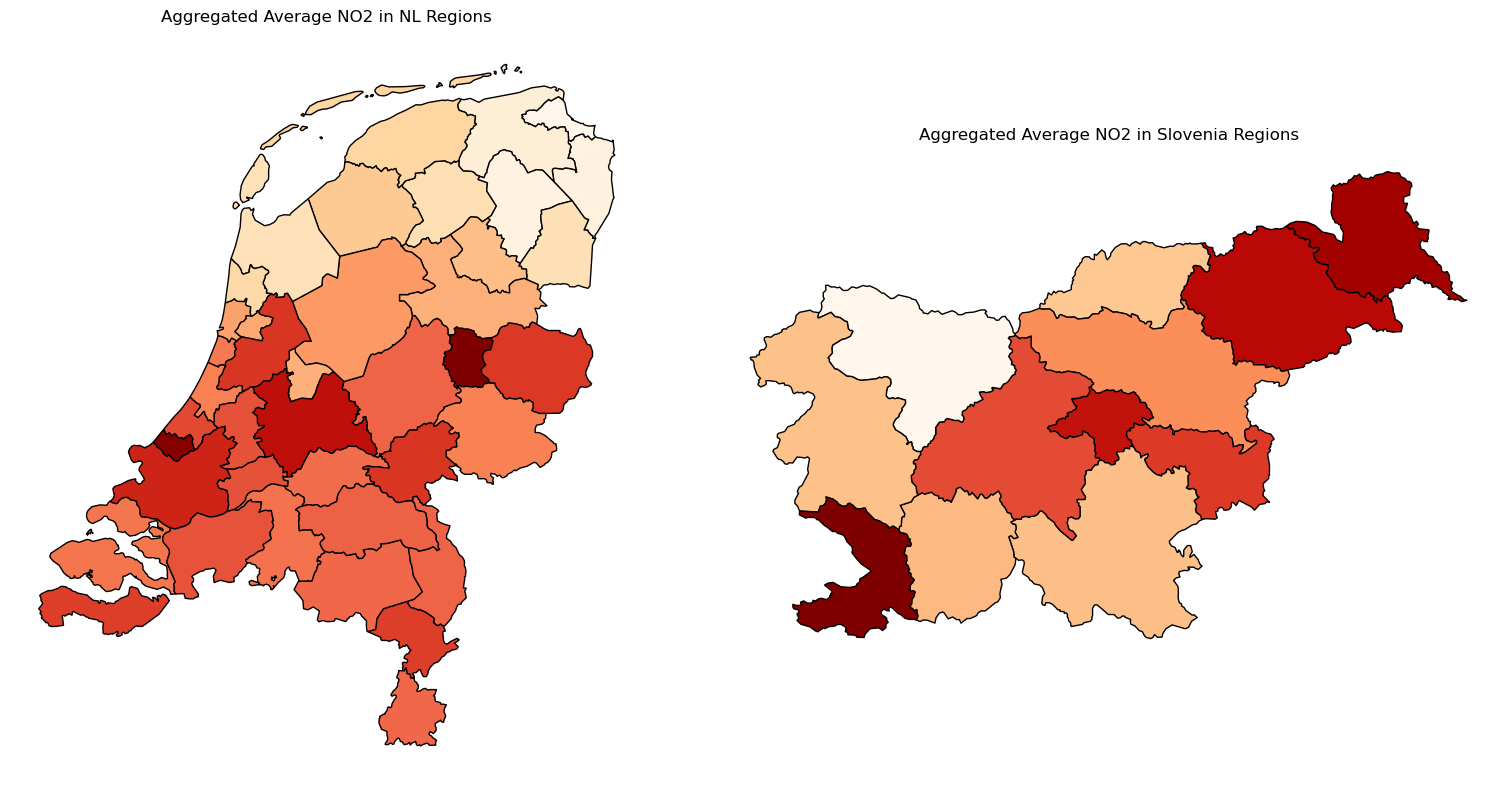

In [86]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the final combined dataframe (which includes geometry)
df = pd.read_csv("combined_pollutant_gdp_data_with_geometry.csv")

# If the geometry column is stored as WKT strings, convert it to actual geometry objects:
from shapely import wkt
df['geometry'] = df['geometry'].apply(wkt.loads)

# Convert dataframe to GeoDataFrame (assuming CRS is EPSG:4326)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Filter data for Netherlands (assuming NUTS_ID starts with 'NL') and Slovenia (starts with 'SI')
gdf_NL = gdf[gdf['NUTS_ID'].str.startswith('NL')]
gdf_SI = gdf[gdf['NUTS_ID'].str.startswith('SI')]

# Aggregate the monthly average over the years for each region (group by NUTS_ID)
# Here, we assume that each row represents a monthly record; we average over all available months & years.
agg_NL = gdf_NL.groupby('NUTS_ID', as_index=False).agg({'NO2': 'mean', 'geometry': 'first'})
agg_SI = gdf_SI.groupby('NUTS_ID', as_index=False).agg({'NO2': 'mean', 'geometry': 'first'})

# Convert the aggregated dataframes back to GeoDataFrames
gdf_agg_NL = gpd.GeoDataFrame(agg_NL, geometry='geometry', crs="EPSG:4326")
gdf_agg_SI = gpd.GeoDataFrame(agg_SI, geometry='geometry', crs="EPSG:4326")

# Plot the aggregated NO2 means for NL and Slovenia on separate map plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for Netherlands
gdf_agg_NL.plot(column='NO2', ax=axes[0], cmap='OrRd', edgecolor='black')
axes[0].set_title("Aggregated Average NO2 in NL Regions")
axes[0].set_axis_off()

# Plot for Slovenia
gdf_agg_SI.plot(column='NO2', ax=axes[1], cmap='OrRd', edgecolor='black')
axes[1].set_title("Aggregated Average NO2 in Slovenia Regions")
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

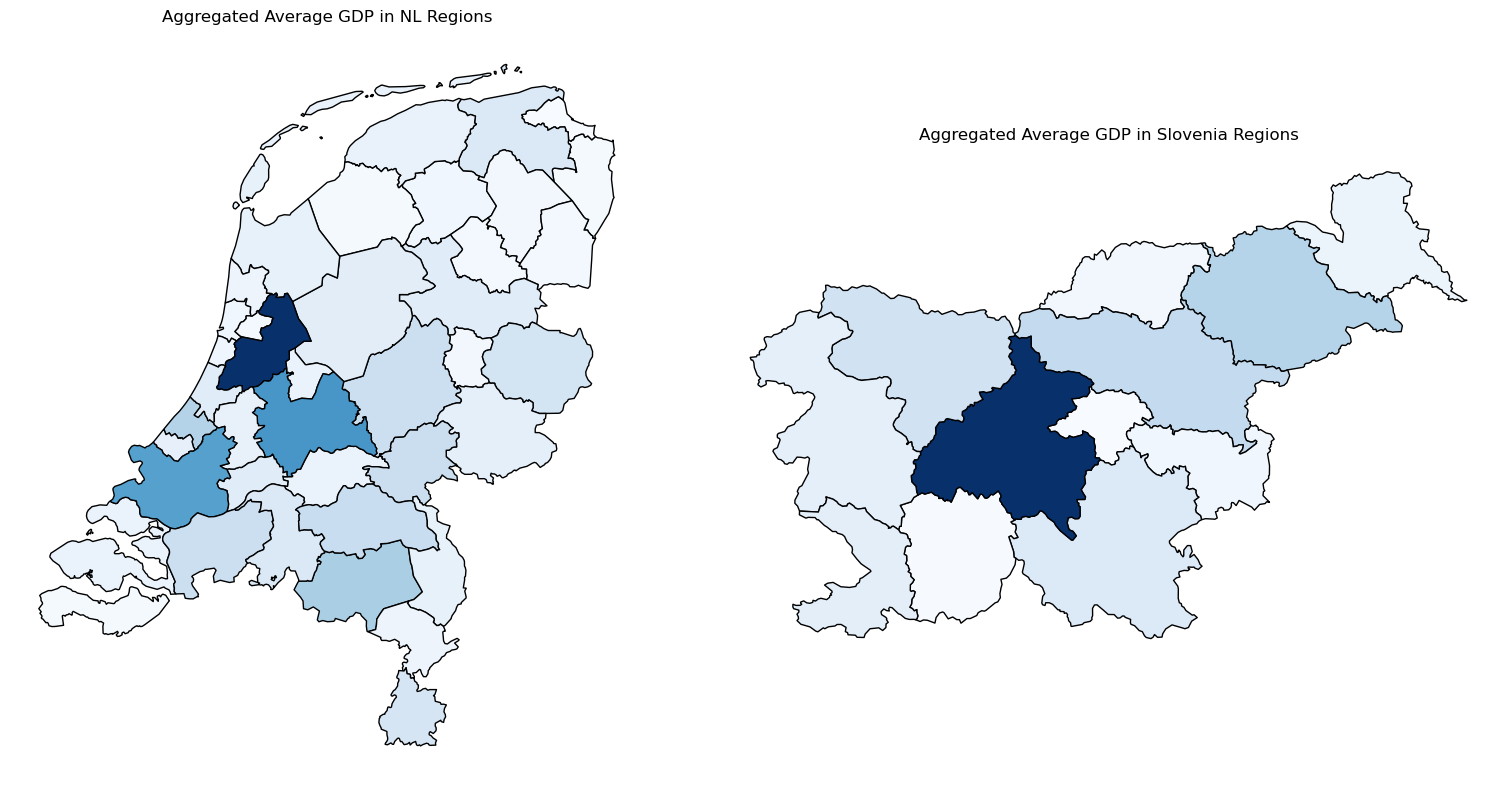

In [89]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the final combined dataframe (which includes geometry and GDP)
df = pd.read_csv("combined_pollutant_gdp_data_with_geometry.csv")

# If the geometry column is stored as WKT strings, convert it to actual geometry objects:
from shapely import wkt
df['geometry'] = df['geometry'].apply(wkt.loads)

# Convert dataframe to GeoDataFrame (assuming CRS is EPSG:4326)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Filter data for Netherlands (assuming NUTS_ID starts with 'NL') and Slovenia (starts with 'SI')
gdf_NL = gdf[gdf['NUTS_ID'].str.startswith('NL')]
gdf_SI = gdf[gdf['NUTS_ID'].str.startswith('SI')]

# Aggregate the monthly average GDP over the years for each region (group by NUTS_ID)
# We assume that 'GDP' is the annual GDP and we average over all available years.
agg_NL = gdf_NL.groupby('NUTS_ID', as_index=False).agg({'GDP': 'mean', 'geometry': 'first'})
agg_SI = gdf_SI.groupby('NUTS_ID', as_index=False).agg({'GDP': 'mean', 'geometry': 'first'})

# Convert the aggregated dataframes back to GeoDataFrames
gdf_agg_NL = gpd.GeoDataFrame(agg_NL, geometry='geometry', crs="EPSG:4326")
gdf_agg_SI = gpd.GeoDataFrame(agg_SI, geometry='geometry', crs="EPSG:4326")

# Plot the aggregated GDP for NL and Slovenia on separate map plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for Netherlands
gdf_agg_NL.plot(column='GDP', ax=axes[0], cmap='Blues', edgecolor='black')
axes[0].set_title("Aggregated Average GDP in NL Regions")
axes[0].set_axis_off()

# Plot for Slovenia
gdf_agg_SI.plot(column='GDP', ax=axes[1], cmap='Blues', edgecolor='black')
axes[1].set_title("Aggregated Average GDP in Slovenia Regions")
axes[1].set_axis_off()

plt.tight_layout()
plt.show()


In [92]:
import pandas as pd

# Define the pollution concentration ranges and their corresponding numerical labels
def categorize_pollutant(value, pollutant_type):
    # Categorize O₃ (mol/m³)
    if pollutant_type == 'O3':
        if value <= 0.05:
            return 1  # Very Good
        elif value <= 0.10:
            return 2  # Good
        elif value <= 0.15:
            return 3  # Medium
        elif value <= 0.20:
            return 4  # Poor
        elif value <= 0.30:
            return 5  # Very Poor
        else:
            return 6  # Extremely Poor
    
    # Categorize CO (mol/m³)
    elif pollutant_type == 'CO':
        if value <= 0.01:
            return 1  # Very Good
        elif value <= 0.02:
            return 2  # Good
        elif value <= 0.03:
            return 3  # Medium
        elif value <= 0.05:
            return 4  # Poor
        elif value <= 0.10:
            return 5  # Very Poor
        else:
            return 6  # Extremely Poor
    
    # Categorize NO₂ (µg/m³)
    elif pollutant_type == 'NO2':
        if value <= 50:
            return 1  # Very Good
        elif value <= 100:
            return 2  # Good
        elif value <= 200:
            return 3  # Medium
        elif value <= 500:
            return 4  # Poor
        elif value <= 1000:
            return 5  # Very Poor
        else:
            return 6  # Extremely Poor
    
    # Categorize SO₂ (µg/m³)
    elif pollutant_type == 'SO2':
        if value <= 50:
            return 1  # Very Good
        elif value <= 100:
            return 2  # Good
        elif value <= 150:
            return 3  # Medium
        elif value <= 200:
            return 4  # Poor
        elif value <= 300:
            return 5  # Very Poor
        else:
            return 6  # Extremely Poor
    
    # Categorize PM2.5 (µg/m³)
    elif pollutant_type == 'PM25':
        if value <= 10:
            return 1  # Very Good
        elif value <= 15:
            return 2  # Good
        elif value <= 20:
            return 3  # Medium
        elif value <= 30:
            return 4  # Poor
        elif value <= 50:
            return 5  # Very Poor
        else:
            return 6  # Extremely Poor
    
    # Categorize HCHO (µg/m³)
    elif pollutant_type == 'HCHO':
        if value <= 5:
            return 1  # Very Good
        elif value <= 10:
            return 2  # Good
        elif value <= 15:
            return 3  # Medium
        elif value <= 20:
            return 4  # Poor
        elif value <= 30:
            return 5  # Very Poor
        else:
            return 6  # Extremely Poor

# Assuming df_final_filled is the dataframe with the pollutant data

# Apply the categorization to each pollutant
df_final_filled['O3_quality'] = df_final_filled['O3'].apply(categorize_pollutant, pollutant_type='O3')
df_final_filled['CO_quality'] = df_final_filled['CO'].apply(categorize_pollutant, pollutant_type='CO')
df_final_filled['NO2_quality'] = df_final_filled['NO2'].apply(categorize_pollutant, pollutant_type='NO2')
df_final_filled['SO2_quality'] = df_final_filled['SO2'].apply(categorize_pollutant, pollutant_type='SO2')
df_final_filled['PM25_quality'] = df_final_filled['PM25'].apply(categorize_pollutant, pollutant_type='PM25')
df_final_filled['HCHO_quality'] = df_final_filled['HCHO'].apply(categorize_pollutant, pollutant_type='HCHO')

# Now, the dataframe includes the numerical quality categories for each pollutant
# You can optionally save this to a new CSV file
df_final_filled.to_csv("combined_pollutant_quality_data_numerical.csv", index=False)

print("Combined dataframe with numerical pollutant quality labels saved as 'combined_pollutant_quality_data_numerical.csv'")


Combined dataframe with numerical pollutant quality labels saved as 'combined_pollutant_quality_data_numerical.csv'


In [94]:
import pandas as pd

# Define seasonal multipliers for each pollutant
seasonal_multipliers = {
    'Winter': {'PM25': 0.40, 'NO2': 0.25, 'O3': 0.10, 'SO2': 0.12, 'CO': 0.06, 'HCHO': 0.07},
    'Spring': {'PM25': 0.36, 'NO2': 0.22, 'O3': 0.15, 'SO2': 0.12, 'CO': 0.07, 'HCHO': 0.08},
    'Summer': {'PM25': 0.25, 'NO2': 0.15, 'O3': 0.30, 'SO2': 0.05, 'CO': 0.10, 'HCHO': 0.15},
    'Autumn': {'PM25': 0.35, 'NO2': 0.23, 'O3': 0.15, 'SO2': 0.12, 'CO': 0.07, 'HCHO': 0.08}
}

# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply the function to create a season column
df_final_filled['season'] = df_final_filled['month'].apply(get_season)

# Create a new set of weighted quality columns for each pollutant
df_final_filled['PM25_weighted_quality'] = df_final_filled.apply(lambda row: row['PM25_quality'] * seasonal_multipliers[row['season']]['PM25'], axis=1)
df_final_filled['NO2_weighted_quality'] = df_final_filled.apply(lambda row: row['NO2_quality'] * seasonal_multipliers[row['season']]['NO2'], axis=1)
df_final_filled['O3_weighted_quality'] = df_final_filled.apply(lambda row: row['O3_quality'] * seasonal_multipliers[row['season']]['O3'], axis=1)
df_final_filled['SO2_weighted_quality'] = df_final_filled.apply(lambda row: row['SO2_quality'] * seasonal_multipliers[row['season']]['SO2'], axis=1)
df_final_filled['CO_weighted_quality'] = df_final_filled.apply(lambda row: row['CO_quality'] * seasonal_multipliers[row['season']]['CO'], axis=1)
df_final_filled['HCHO_weighted_quality'] = df_final_filled.apply(lambda row: row['HCHO_quality'] * seasonal_multipliers[row['season']]['HCHO'], axis=1)

# Now, the dataframe includes the weighted quality columns
# You can save this updated dataframe to a new CSV file if needed
df_final_filled.to_csv("combined_pollutant_weighted_quality_data.csv", index=False)

print("Combined dataframe with weighted quality columns saved as 'combined_pollutant_weighted_quality_data.csv'")


Combined dataframe with weighted quality columns saved as 'combined_pollutant_weighted_quality_data.csv'


In [97]:
# Create a new column 'Air_quality_Index' which is the sum of the weighted quality columns
df_final_filled['Index'] = df_final_filled['PM25_weighted_quality'] + \
                                       df_final_filled['NO2_weighted_quality'] + \
                                       df_final_filled['O3_weighted_quality'] + \
                                       df_final_filled['SO2_weighted_quality'] + \
                                       df_final_filled['CO_weighted_quality'] + \
                                       df_final_filled['HCHO_weighted_quality']

# Print the dataframe to verify the new column
print(df_final_filled[['PM25_weighted_quality', 'NO2_weighted_quality', 'O3_weighted_quality', 
                       'SO2_weighted_quality', 'CO_weighted_quality', 'HCHO_weighted_quality', 
                       'Index']].head())


   PM25_weighted_quality  NO2_weighted_quality  O3_weighted_quality  \
0                   0.40                  0.25                  0.4   
1                   0.40                  0.25                  0.3   
2                   0.72                  0.22                  0.6   
3                   0.72                  0.22                  0.6   
4                   0.72                  0.22                  0.6   

   SO2_weighted_quality  CO_weighted_quality  HCHO_weighted_quality  Index  
0                  0.24                 0.24                   0.07   1.60  
1                  0.12                 0.24                   0.07   1.38  
2                  0.12                 0.28                   0.08   2.02  
3                  0.12                 0.28                   0.08   2.02  
4                  0.12                 0.28                   0.08   2.02  


In [102]:
# Step 1: Extract the country from NUTS_ID (first two letters)
df_final_filled['Country'] = df_final_filled['NUTS_ID'].str[:2]

# Reset the index without adding index columns back
df_final_filled = df_final_filled.reset_index(drop=True)

# Step 2: Calculate GDP min and max for each country and year
df_final_filled['GDP_min'] = df_final_filled.groupby(['Country', 'year'])['GDP'].transform('min')
df_final_filled['GDP_max'] = df_final_filled.groupby(['Country', 'year'])['GDP'].transform('max')

# Check the result
print(df_final_filled[['NUTS_ID', 'year', 'Country', 'GDP', 'GDP_min', 'GDP_max']].head())


  NUTS_ID  year Country      GDP  GDP_min    GDP_max
0   NL112  2018      NL  2464.02  2464.02  121326.45
1   NL112  2018      NL  2464.02  2464.02  121326.45
2   NL112  2018      NL  2464.02  2464.02  121326.45
3   NL112  2018      NL  2464.02  2464.02  121326.45
4   NL112  2018      NL  2464.02  2464.02  121326.45


In [104]:
type(df_final_filled)

pandas.core.frame.DataFrame

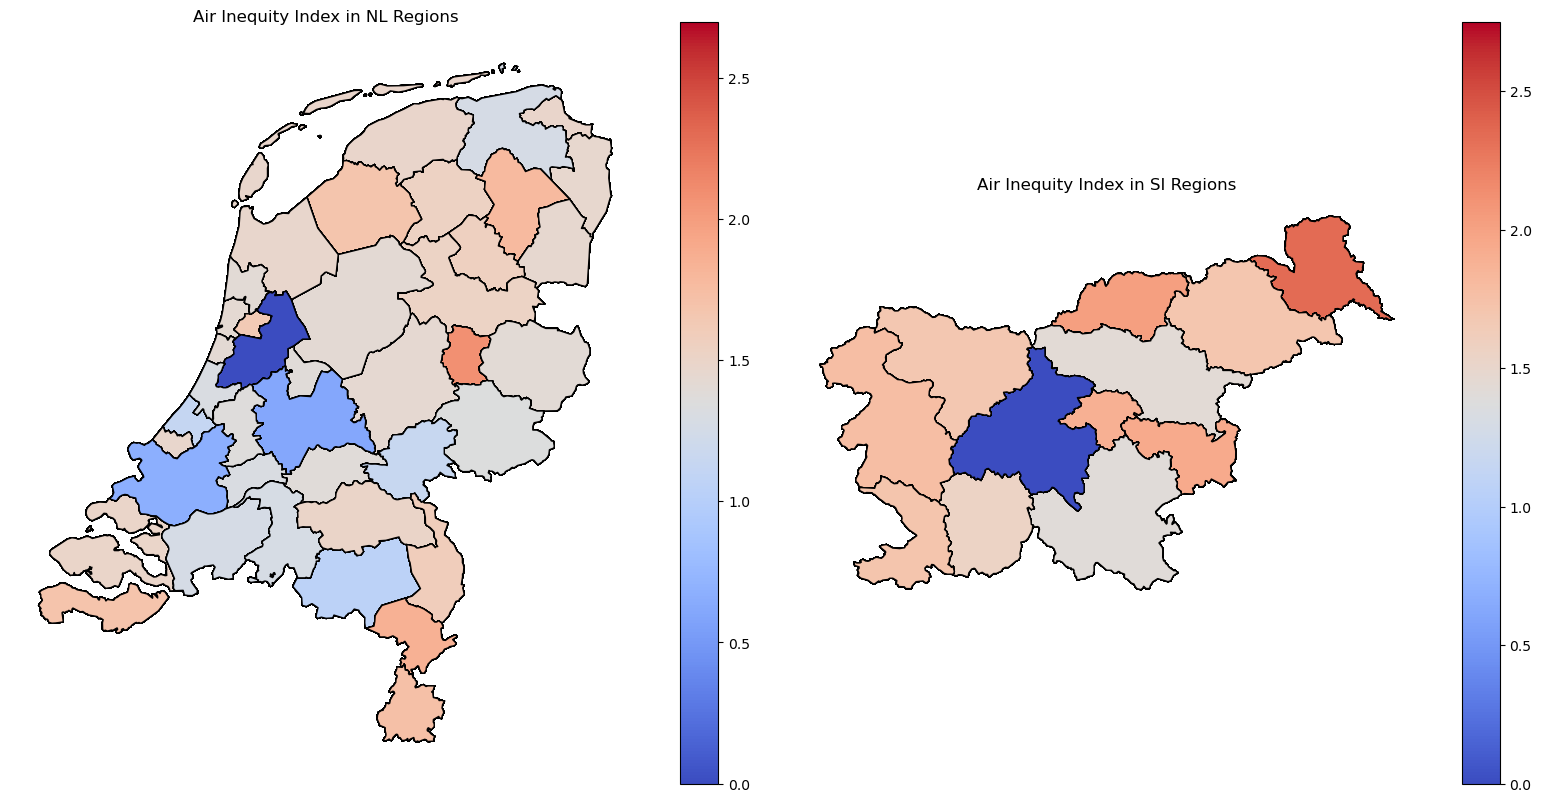

In [110]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Read the shapefiles and extract geometry ---
shapefile_paths = ["NUTS_NL_01m_2024.shp", "NUTS_SL_01m_2024.shp"]  # Provide paths to your shapefiles

gdf_list = []

for shp in shapefile_paths:
    # Read the shapefile
    gdf = gpd.read_file(shp)
    
    # Ensure the CRS is WGS84
    if gdf.crs.to_string() != "EPSG:4326":
        gdf = gdf.to_crs(epsg=4326)
    
    # Select only the NUTS_ID and geometry columns
    gdf = gdf[['NUTS_ID', 'geometry']]
    
    # Rename the geometry column to avoid conflict during merge
    gdf = gdf.rename(columns={'geometry': 'geometry_gdf'})
    
    gdf_list.append(gdf)

# Combine the two GeoDataFrames into one
geometry_gdf = pd.concat(gdf_list, ignore_index=True)

# Optional: drop duplicates if the same NUTS_ID appears in both files
geometry_gdf = geometry_gdf.drop_duplicates(subset='NUTS_ID')

# --- Step 2: Assuming 'df_final_filled' already contains the 'GDP_Normalized' and 'Air Quality Index' columns ---

# Calculate Air Inequity Index
df_final_filled['Air_Inequity_Index'] = df_final_filled['GDP_Normalized'] * df_final_filled['Index']

# --- Step 3: Merge the geometry data into the final dataframe ---
df_final_filled = df_final_filled.merge(geometry_gdf, on='NUTS_ID', how='left')

# --- Step 4: Extract Netherlands (NL) and Slovenia (SI) regions ---
df_NL = df_final_filled[df_final_filled['Country'] == 'NL']
df_SI = df_final_filled[df_final_filled['Country'] == 'SI']

# Convert to GeoDataFrame
gdf_NL = gpd.GeoDataFrame(df_NL, geometry='geometry_gdf', crs="EPSG:4326")
gdf_SI = gpd.GeoDataFrame(df_SI, geometry='geometry_gdf', crs="EPSG:4326")

# --- Step 5: Plot the Air Inequity Index for both countries ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for Netherlands (NL)
gdf_NL.plot(column='Air_Inequity_Index', ax=axes[0], legend=True, cmap='coolwarm', edgecolor='black')
axes[0].set_title("Air Inequity Index in NL Regions")
axes[0].set_axis_off()

# Plot for Slovenia (SI)
gdf_SI.plot(column='Air_Inequity_Index', ax=axes[1], legend=True, cmap='coolwarm', edgecolor='black')
axes[1].set_title("Air Inequity Index in SI Regions")
axes[1].set_axis_off()

plt.tight_layout()
plt.show()


In [115]:
df_final_filled.to_csv('final_v1.csv')

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Check the first few rows of the 'geometry' column to determine its format
print(df_final_filled['geometry'].head())

# If the geometry is in WKT format, you can convert it like this:
# If the geometry column is a WKT string, convert it to actual geometry objects
if isinstance(df_final_filled['geometry'].iloc[0], str):  # Check if the geometry column contains strings
    df_final_filled['geometry'] = df_final_filled['geometry'].apply(wkt.loads)

# Otherwise, if the geometry is already in Shapely format (e.g., MultiPolygon), skip the conversion step
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df_final_filled, geometry='geometry', crs="EPSG:4326")

# Save as shapefile
gdf.to_file("final_v2.shp", driver="ESRI Shapefile")
print("Shapefile has been successfully exported.")


In [123]:
df_final_filled.to_csv('final_v2.csv')